In [ ]:
# demo: loads file with all messages (CSTARTTIME, CSENDERENDPOINTID, ymdhm )
# show some charts, anomaly detection with LSTM autoencoders

In [1]:
import base.dfBasics as dfBasics
import base.common as common
import base.encoder as encoder
import base.pfAdapt as pfAdapt
import base.charts as charts
import base.anomaly as anomaly

import pandas as pd
from pyspark.sql import functions

Setup Complete


ModuleNotFoundError: No module named 'tensorflow'

In [2]:
sparkSession = dfBasics.getSparkSession()
#df = sparkSession.read.parquet('hdfs://172.30.17.145:8020/user/admin/sla/CSENDERENDPOINTID/CSENDERENDPOINTID_9.parquet')
#df = sparkSession.read.parquet('hdfs://172.30.17.145:8020/user/admin/sla/sla_1580137124017.parquet')
#df = sparkSession.read.parquet('hdfs://172.30.17.145:8020/user/admin/sla/sla_1616754087742.parquet')
#df = sparkSession.read.parquet('hdfs://172.30.17.145:8020/user/admin/CSENDERENDPOINTID/CSENDERENDPOINTID_2191.parquet')
df = sparkSession.read.parquet('hdfs://172.30.17.145:8020/user/admin/CSENDERENDPOINTID_full/CSENDERENDPOINTID_9.parquet')
pfall = df.toPandas()

In [3]:
## Setup charts
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")

def get_ym_string(a,b) :
    return a + "-" + b
    #return a.join(["-",b]) 

def get_ym(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    return a,b

def get_ymd(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    c = mdcountsall.index.get_level_values(2).astype(str)
    return a,b,c

def make_2digits(blist):
    for n, b in enumerate(blist):
        if int(b) < 10:
             blist[n] = '0' + str(b)
    return blist

def get_ymd_string(a,b,c) :
    if isinstance(a, str) :
        return a + "-" + make_2digits([b])[0] + "-" + make_2digits([c])[0] 
    return a + "-" + pd.Index(make_2digits(b.tolist())) + "-" + pd.Index(make_2digits(c.tolist())) 

def get_ymdh(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    c = mdcountsall.index.get_level_values(2).astype(str)
    d = mdcountsall.index.get_level_values(3).astype(str)
    return a,b,c,d

def get_ymdh_string(a,b,c,d) :
    return a + "-" + b + "-" + c + "-" + d

def createData_ym(pfall,month) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['month'] == month)].groupby(['year','month'])['year'].count()
    else :
        mdcountsall = pfall.groupby(['year','month'])['year'].count()    
    a,b = get_ym(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ym_string(a,b)
    data2['outcome'] = mdcountsall.reset_index(level=0, drop=True).reset_index()['year'].astype(int) 
    return data2

def createData(pfall,month) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['month'] == month)].groupby(['year','month','day','hour'])['year'].count()
    else :
        mdcountsall = pfall.groupby(['year','month','day','hour'])['year'].count()    
    a,b,c,d = get_ymdh(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ymdh_string(a,b,c,d)
    data2['outcome'] =  mdcountsall.reset_index(level=0, drop=True).reset_index()['year'].astype(int)

    #for pivot table
    data2['hours'] =  d.astype(int) 
    data2['days']  =  c.astype(int) 
    return data2

def createData_ymd(pfall,month) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['month'] == month)].groupby(['year','month','day'])['year'].count()
    else :
        mdcountsall = pfall.groupby(['year','month','day'])['year'].count()    
    a,b,c = get_ymd(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ymd_string(a,b,c)
    data2['year'] = a.astype(int) 
    data2['month'] = b.astype(int) 
    data2['day'] = c.astype(int) 
    data2['outcome'] = mdcountsall.reset_index(level=0, drop=True).reset_index()['year'].astype(int) 
    return data2

def label(graph,skip,rot) :
    for ind, label in enumerate(graph.get_xticklabels()):
        if ind % skip == 0:  # every 10th label is kept
            label.set_visible(True)
            label.set_rotation(rot)
        else:
            label.set_visible(False)

def createBarplot(md=None,fx=24,fy=12,fontscale=3.0,title="") :
    sns.set(style='whitegrid', palette='muted', font_scale=fontscale)
    plt.figure(figsize=(fx,fy))
    plt.title(title)
    ax = sns.barplot(x=md['date'], y=md['outcome'], data=md)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=75 )
    plt.tight_layout()
    plt.show()
    return ax

## heatmap
def createHeatmap(piv,title="") :
    plt.figure(figsize=(24,8))
    plt.title(title)
    ax = sns.heatmap(piv, square=True)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=0 )
    plt.tight_layout()
    plt.show()
    return ax

Setup Complete


In [4]:
make_2digits([4])

['04']

In [5]:
pfall1 = pfall.sort_values(['year','month','day','hour']).reset_index()
del pfall1['index']
del pfall1['CGLOBALMESSAGEID']

In [6]:
pfall

,CGLOBALMESSAGEID,year,month,day,hour,CSTATUS,CSERVICE,CSENDERPROTOCOL,CINBOUNDSIZE,CRECEIVERPROTOCOL,CRECEIVERENDPOINTID,CSLATAT,CMESSAGETAT2,CSLADELIVERYTIME
0,6878249240966155692,2020,1,15,5,11,5,0,2293,0,725,6159,7495,1579063677504
1,-3549930604559515972,2020,1,15,5,11,5,0,2293,0,725,6239,7205,1579063703375
2,7294079960648046876,2020,1,15,7,11,5,0,2445,0,725,227454,276896,1579071191028
3,4593600892465465186,2020,1,15,9,11,5,0,2359,0,725,6285,40731,1579076545891
4,-1466978904100060073,2020,1,15,10,11,5,0,854,0,725,6160,43341,1579081703258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1782420,-7897740044678644349,2020,4,5,22,11,5,0,614,0,725,5640,5790,1586117600585
1782421,-6783699335817719085,2020,4,5,22,11,5,0,30549,0,725,4485,4637,1586117117778
1782422,3176671547071877123,2020,4,5,22,11,5,0,599,0,725,5185,5324,1586117624175
1782423,-541979808772834438,2020,4,5,22,11,5,0,602,0,725,4661,4804,1586117595455


In [7]:
from calendar import monthrange
monthrange(2020, 1)[1]

31

In [ ]:
pfall0 = pfall[pfall['CRECEIVERENDPOINTID']==725]
pda = createData_ymd(pfall0,0)

In [ ]:
pda

In [8]:
#pd['a'] = pd['a'].astype(int) 
#pda[(pda['month'] == 2) & (pda['year'] == 2021)]

def check_complete(year=2020):
    for m in range(1, 13):
        mm = pda[(pda['month'] == m) & (pda['year'] == year)]
        print(m,monthrange(year, m)[1] == len(mm))

def fill(pda,year,month):        
    days = monthrange(year, month)[1]
    df = pda[(pda['month'] == month) & (pda['year'] == year)]
    for day in range(1, days + 1):
        if len(df[df['day']==day]) == 0:
            pda.loc[len(pda)]=[get_ymd_string(str(year),str(month),str(day)),year,month,day,0]
    
#fill(pda,2019,11)     
#fill(pda,2019,12) 
#pda = pda.sort_values(['date']).reset_index()

#df = pda[(pda['month'] == 11) & (pda['year'] == 2019)]    
#check_complete(2019)
#len(df[df['day']==30])
#pda.loc[521]


In [ ]:
check_complete(2021)
#pda[(pda['month'] == 11) & (pda['year'] == 2020)]  

In [16]:
def unique(pfall):
    return pd.unique(pfall['CRECEIVERENDPOINTID']), pd.unique(pfall['CSTATUS']), pd.unique(pfall['CSERVICE']), pd.unique(pfall['CSENDERPROTOCOL']), pd.unique(pfall['CRECEIVERPROTOCOL'])

un=unique(pfall)
#unique(pfall[pfall['CRECEIVERENDPOINTID']==725])

pfall0 = pfall[pfall['CRECEIVERENDPOINTID']==un[0][1]]
pda = createData_ymd(pfall0,0)

In [17]:
fill(pda,2019,11)     
fill(pda,2019,12) 
fill(pda,2020,1)
fill(pda,2020,2)
fill(pda,2020,3)
fill(pda,2020,4)
fill(pda,2020,5)
fill(pda,2020,6)
fill(pda,2020,7)
fill(pda,2020,8)
fill(pda,2020,9)
fill(pda,2020,10)
fill(pda,2020,11)
fill(pda,2020,12)
fill(pda,2021,1)
fill(pda,2021,2)
fill(pda,2021,3)
pda = pda.sort_values(['date']).reset_index()

In [18]:
pfall1 = pda

In [ ]:
pda

In [19]:
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

# new

In [88]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

# Time Series Anomaly Detection with LSTM Autoencoders (selected sender)

In [20]:
%%capture
import AnomalyDetectionLSTMAutoencoder
anomalyEnc = AnomalyDetectionLSTMAutoencoder.AnomalyDetectionLSTMAutoencoder(TIME_STEPS = 30)
anomalyEnc.initAndTrain(pfall1,0.7)
#anomalyEnc.__dict__

In [44]:
len(pfall1),  len(anomalyEnc.train), len(anomalyEnc.test), len(anomalyEnc.y_test), len(anomalyEnc.df1), len(anomalyEnc.train), len(anomalyEnc.test),anomalyEnc.TIME_STEPS, len(anomalyEnc.X_train), len(anomalyEnc.y_train)

(522, 365, 157, 127, 522, 365, 157, 30, 335, 335)

In [87]:
X = anomalyEnc.train[[anomalyEnc.OUTCOME]]['close']
y = anomalyEnc.train['close']
#len(anomalyEnc.X_train[0]), type(anomalyEnc.y_train[0])
#X.head(), y.head()
time_steps = 30
i=334
v = X.iloc[i:(i + time_steps)].values
v,y[i + time_steps],i + time_steps
#len(X) ,len(X) - time_steps
#X.values[130]

(array([-0.08131461, -0.27657665,  3.04287813,  0.11394744, -0.08131461,
         0.7973646 , -0.27657665,  0.21157846,  0.01631642, -0.37420767,
         0.99262665,  0.69973358, -0.27657665, -0.08131461, -0.17894563,
        -0.37420767, -0.37420767, -0.37420767, -0.37420767,  2.0665679 ,
        -0.08131461, -0.27657665,  0.60210255,  0.11394744,  0.50447153,
        -0.17894563, -0.37420767,  1.28551971,  0.11394744,  1.09025767]),
 -0.3742076739849797,
 364)

In [ ]:
#anomalyEnc.model.save("/tmp/my_model/",save_format="tf")
#anomalyEnc.model.save("/tmp/mymodel.h5", save_format="h5")
#anomalyEnc.createDataframe(pfall1)
#pfall1

In [ ]:
data = sns.distplot(anomalyEnc.train_mae_loss, bins=50, kde=True).get_lines()[0].get_data()
#data[0][25], data[1][25]

In [ ]:
#threshold_X = data[0][25]
#threshold_X = 0.4
#anomalyEnc.evaluateAnomalies(threshold_X)

In [30]:
%%capture
import numpy as np

anomalyEnc.test_score_df      = anomalyEnc.testScoreDF(anomalyEnc.model, 0.0, anomalyEnc.X_test, anomalyEnc.test)

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
data = plt.plot(anomalyEnc.test_score_df.index, anomalyEnc.test_score_df.loss, label='loss')

y=plt.getp(data[0],'ydata')

#threshold_X = 0.98 * np.max(y)
threshold_X = np.max(y) - 0.0001
anomalyEnc.evaluateAnomalies(threshold_X)

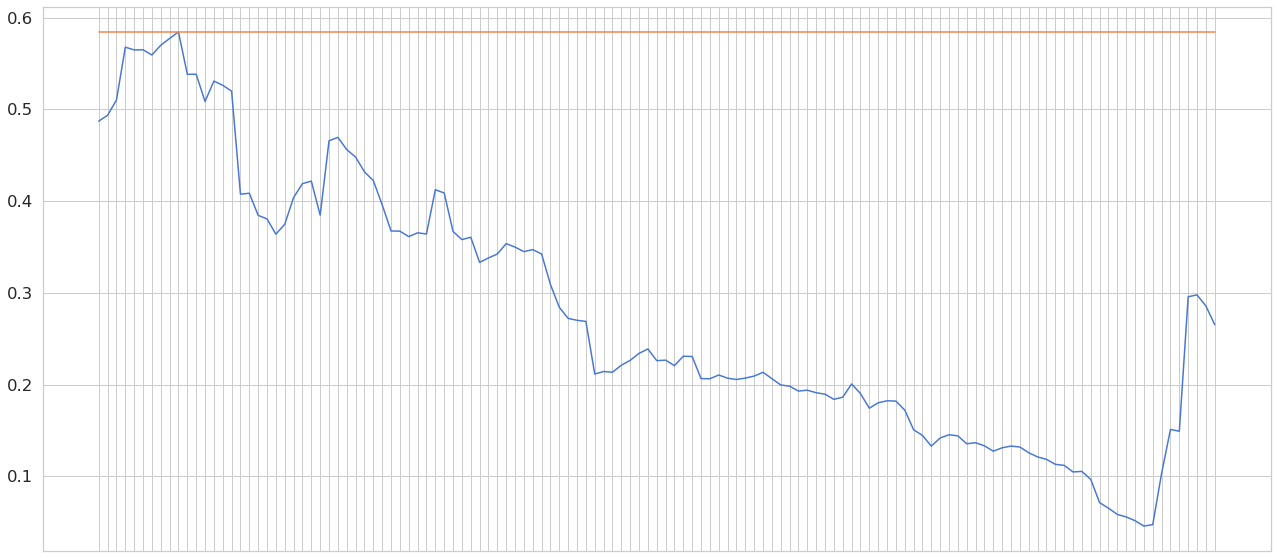

In [31]:
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 

plt.plot(anomalyEnc.test_score_df.index, anomalyEnc.test_score_df.loss, label='loss')
plt.plot(anomalyEnc.test_score_df.index, anomalyEnc.test_score_df.threshold, label='threshold')
#plt.xticks(rotation=25)
#plt.legend();

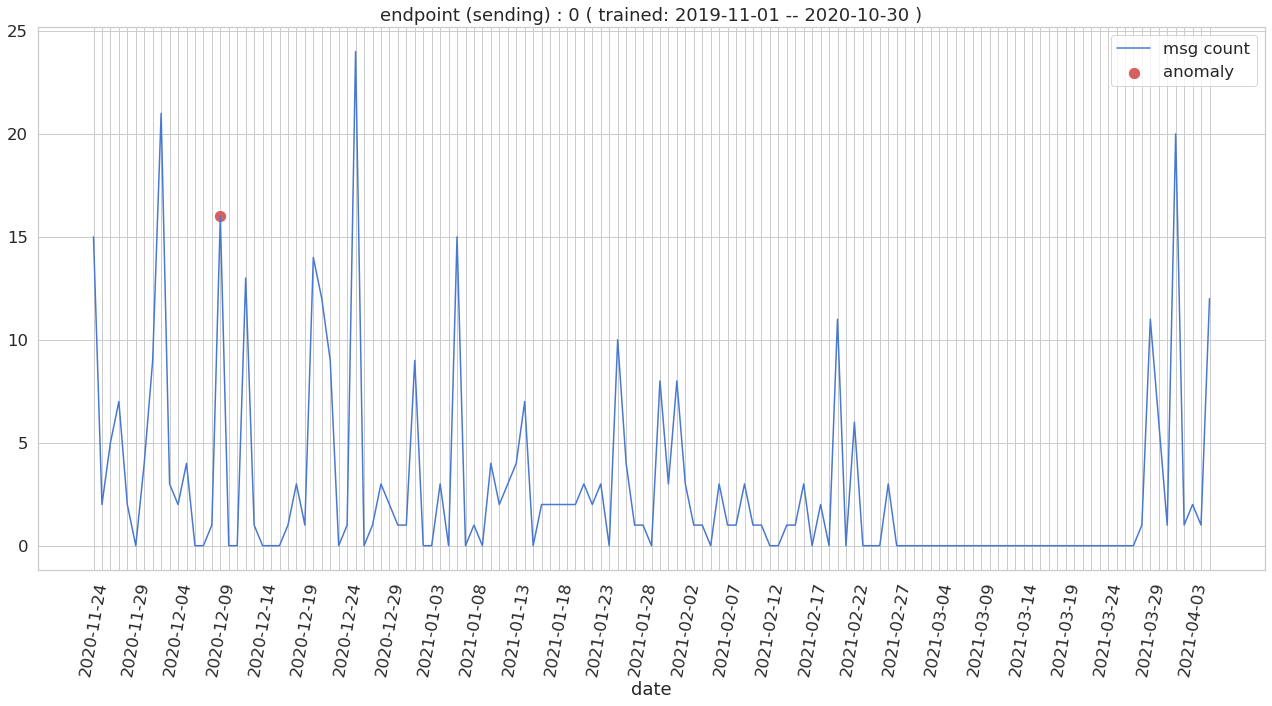

In [32]:
sender = 0
titlestring ="endpoint (sending) : " + str(sender) + " ( trained: " +  anomalyEnc.train.index[0] + " -- " + anomalyEnc.train.index[len(anomalyEnc.train.index)-1] + " )"
anomaly.plot_test(anomalyEnc.test,anomalyEnc.scaler,anomalyEnc.anomalies,titlestring)

In [ ]:
anomalyEnc.anomalies.index

In [ ]:
pda[pda['date'] == anomalyEnc.anomalies.iloc[0].name]
#pfall1.head()
#pfall1
#pda
#pda['date'] == anomalyEnc.anomalies.iloc[0].name

In [ ]:
anomalyEnc.test[100:]

In [ ]:
anomalyEnc.anomalies.iloc[0].name, pda['date'][0]

In [ ]:
data2 = createData(pfall,3)
piv = pd.pivot_table(data2, values="outcome",index=["hours"], columns=["days"], fill_value=0)
createHeatmap(piv, '')